In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

reload()
# !pip install matplotlib-venn

In [2]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
len ([x for _, x in load_work_map_all_years() if x.category == "snowball"])

22

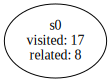

In [4]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


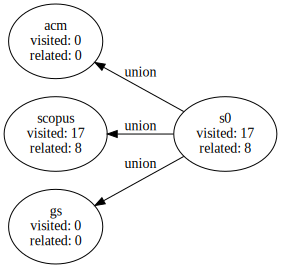

In [5]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["acm", "scopus", "gs"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [6]:
array = []

name = "E1"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E1
0.47058823529411764
Recall E1
0.36363636363636365


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

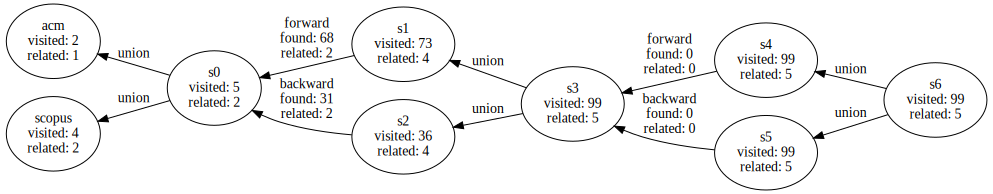

In [7]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

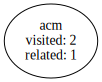

In [8]:
strategy.initial.find("acm")

In [9]:
# Visitados ACM
strategy.initial.find("acm").visited

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Cross-vs. within-company cost estimation studies revisited: an extended systematic review}

In [10]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("acm").related

{Further comparison of cross-company and within-company effort estimation models for web applications}

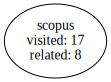

In [7]:
strategy.initial.find("scopus")

In [8]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{Software process improvement for the airline industry,
 A comparative study of SPI approaches with ProPAM,
 Application of GQM+Strategies® in the Japanese space industry,
 Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 Empirical evaluation of selected best practices in implementation of software process improvement,
 Using strategic planning for selection of SPI processes: An experience report,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Software process improvement: Supporting the linking of the software and the business strategies,
 Demanding change: How to remain in business despite IT,
 Software engineering strategies: Aligning software process improvement with strategic goals,
 SPI: 'I can't get no satisfaction

In [9]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{Application of GQM+Strategies® in the Japanese space industry,
 Software process improvement: Supporting the linking of the software and the business strategies,
 SPI: 'I can't get no satisfaction' - Directing process improvement to meet business needs,
 Software engineering strategies: Aligning software process improvement with strategic goals,
 Propamet: A metric for process and project alignment,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 An approach to support the strategic alignment of software process improvement programs,
 A low-overhead method for software process appraisal}

In [10]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [15]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


94

In [16]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{Cross versus within-company cost estimation studies: A systematic review,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Building software cost estimation models using homogenous data}

In [17]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s0").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review',
 'kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications',
 'premraj2007a - Building software cost estimation models using homogenous data']

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [18]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Cross-vs. within-company cost estimation studies revisited: an extended systematic review,
 Using public domain metrics to estimate software development effort}

#### Relacionados - Seed Set

In [19]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['mendes2004a - Further comparison of cross-company and within-company effort estimation models for web applications',
 'ferrucci2012a - Web effort estimation: The value of cross-company data set compared to single-company data set']

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [20]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{Applied statistics for software managers,
 Software cost models,
 When to use data from other projects for effort estimation,
 Individual comparisons by ranking methods,
 Using simulation to evaluate prediction techniques,
 A study of project selection and feature weighting for analogy based software cost estimation,
 Investigating early web size measures for web cost estimation,
 Case studies for method and tool evaluation,
 Cross-company vs. single-company web effort models using the Tukutuku database: An extended study,
 What accuracy statistics really measure,
 Effort estimation: how valuable is it for a web company to use a cross-company data set, compared to using its own single-company data set?,
 Statistical power analysis for the behavioral sciences,
 Software engineering metrics and models,
 A procedure for analyzing unbalanced datasets,
 Detection of influential observation in linear regression,
 How to find relevant data for effort estimation?,
 How valuable is company-spe

In [21]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review',
 'kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [22]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review',
 'premraj2007a - Building software cost estimation models using homogenous data']

#### Relacionados - Encontrados Via Backward e Forward

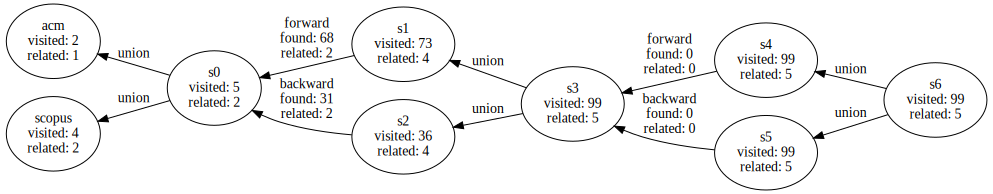

In [23]:
state

In [24]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm").visited) + len(strategy.initial.find("scopus").visited)) - len(state.find("s0").visited)

1

In [25]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review',
  'kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications'],
 ['kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review',
  'premraj2007a - Building software cost estimation models using homogenous data']]

In [26]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [27]:
strategy.forward??

In [28]:
duplicados(strategy, state)

0

In [71]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [72]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['kitchenham2007a', 'kitchenham2004a']
Forward ['kitchenham2007a', 'premraj2007a']


In [31]:
state.find("s0").related @ metakey

['mendes2004a', 'ferrucci2012a']

In [32]:
#x = v.get_patch_by_id('100')

In [33]:
#x.set_linestyle = "black"

In [34]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [35]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward mendes2004a
- christodoulou2000a 
- mendes2003b 
- kitchenham2001a 
- shepperd2001a 
- kitchenham2004a related
- briand2000a 
- maxwell2002a 
- kitchenham1984a 
- mendes2003a 
- kitchenham1998a 
- briand1999a 
- cook1977a 
- wilcoxon1945a 
- kemerer1987a 
- wieczorek2002a 
forward mendes2004a
- mendes2008b 
- kitchenham2007a related
- mendes2005b 
- kocaguneli2010a 
- mendes2007a 
backward ferrucci2012a
- kitchenham2007a related
- mendes2005a 
- maxwell2002a 
- kocaguneli2010a 
- shepperd2001a 
- menzies2011a 
- kitchenham2004a related
- li2009a 
- mendes2003a 
- kitchenham1995a 
- kocaguneli2012a 
- mendes2008b 
- kitchenham2001a 
- mendes2007a 
- cohen1988a 
- turhan2009a 
- conte1986a 
- mendes2005b 
- mendes2008a 
- kitchenham1998a 
- cook1977a 
- mendes2002a 
- kocaguneli2011a 


#### Execução de Forward em cada artigo relacionado do S1

In [36]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward mendes2004a
- watanabe2008a 
- martino2011a 
- kitchenham2007a related
- mendes2007c 
- mendes2008e 
- shepperd2012a 
- francese2015a 
- premraj2005a 
- kocaguneli2010a 
- keung2008b 
- martino2016a 
- baker2010a 
- azhar2013a 
- al2006a 
- mendes2007b 
- wen2012a 
- ferrucci2010a 
- ferrucci2010b 
- mendes2009b 
- huang2008a 
- lokan2006a 
- ferrucci2009a 
- matos2013a 
- corazza2009a 
- mittas2010a 
- costagliola2006b 
- premraj2007a related
- marco2013a 
- corazza2011a 
- mendes2005c 
- corazza2013a 
- lall2006a 
- mendes2008b 
- mair2005a 
- costagliola2006a 
- mittas2010b 
- keung2009a 
- minku2015a 
- martino2009a 
- abrahão2010a 
- mittas2015a 
- mendes2007a 
- marco2012a 
- baresi2007a 
- mendes2009a 
- martino2007a 
- zimmermann2009a 
- mendes2007d 
- mendes2005b 
- mendes2008d 
- keung2008a 
- wieringa2015a 
- ferrucci2008a 
- kitchenham2006a 
- lokan2008a 
- lang2009a 
- buglione2010a 
- ferrucci20

#### Resumo do Precision e Recall

In [37]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.40%

Precision no Snowballing E2: 0.03%
Precision no Snowballing E2 - Forward - 1 iteração: 0.03%
Precision no Snowballing E2 - Backward - 1 iteração: 0.06%

Precision E2 (Busca + Snowballing): 0.05%
Precision E2
0.050505050505050504
Recall E2
1.0


In [38]:
0 /0 

ZeroDivisionError: division by zero

In [73]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [74]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

5,state,precision,recall,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall
0,s0,0.5,0.4,-,2,4,2,4,0.5,0.4
1,s1,0.0289855,0.4,forward,4,73,2,69,0.0547945,0.8
2,s2,0,0,forward,4,73,0,0,0.0547945,0.8
3,s3,0.0384615,0.2,backward,5,99,1,26,0.0505051,1
4,s4,0,0,backward,5,99,0,0,0.0505051,1


<IPython.core.display.Javascript object>


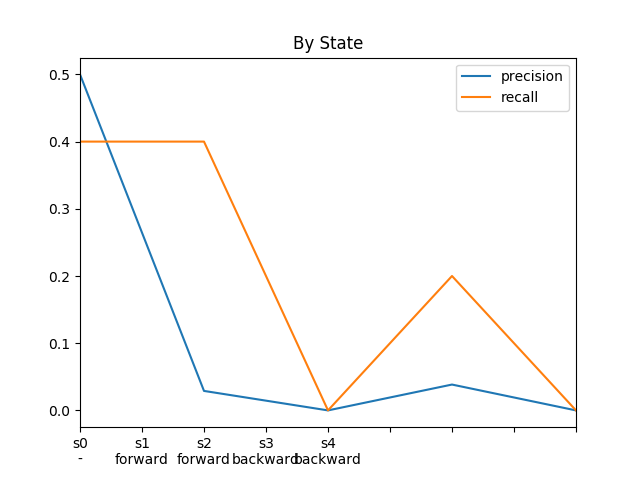

In [75]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

<IPython.core.display.Javascript object>


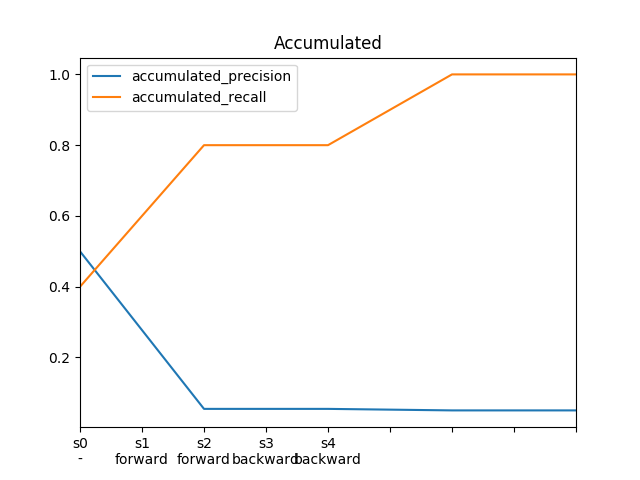

In [76]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

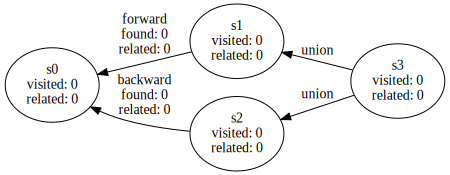

In [39]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [40]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3


ZeroDivisionError: division by zero

## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

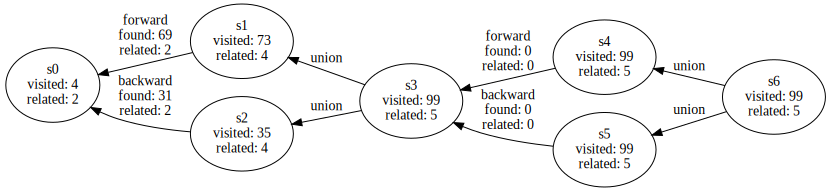

In [41]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.sfbu()
state

In [42]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E4
0.050505050505050504
Recall E4
1.0


In [43]:
state.find("s0").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [44]:
state.find("s2").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Cross versus within-company cost estimation studies: A systematic review}

In [45]:
state.find("s0").visited

{A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Using public domain metrics to estimate software development effort,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [46]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [47]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [48]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

{Cross versus within-company cost estimation studies: A systematic review,
 Building software cost estimation models using homogenous data}

In [49]:
len(state.find("s1").delta_visited)

69

In [50]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

60

In [51]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

17

In [52]:
search_state = strategy.initial
search_state.related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

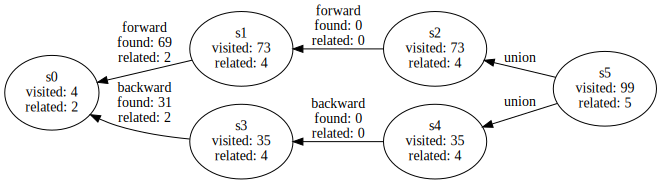

In [53]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [54]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E5
0.050505050505050504
Recall E5
1.0


In [55]:
state.find("s0").related 

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [56]:
state.find("s1").related 

{Building software cost estimation models using homogenous data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Cross versus within-company cost estimation studies: A systematic review}

In [57]:
state.find("s5").related 

{Cross versus within-company cost estimation studies: A systematic review,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Building software cost estimation models using homogenous data}

In [58]:
sx, sy = state.previous[0]

sx.related & sy.related


{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Cross versus within-company cost estimation studies: A systematic review}

In [59]:
sx.name

's2'

In [60]:
sy.name

's4'

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

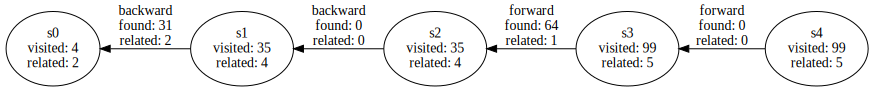

In [61]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [62]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E6
0.050505050505050504
Recall E6
1.0


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

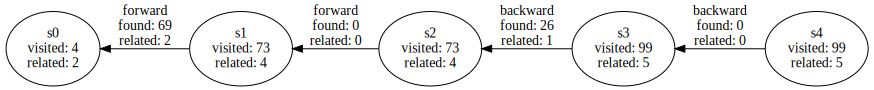

In [63]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [64]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E7
0.050505050505050504
Recall E7
1.0


# Análise das Estratégias

In [65]:
%matplotlib notebook
import pandas as pd

In [78]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.500000,0.4
E2,E2,0.050505,1.0
E4,E4,0.050505,1.0
E5,E5,0.050505,1.0
E6,E6,0.050505,1.0
E7,E7,0.050505,1.0


<IPython.core.display.Javascript object>


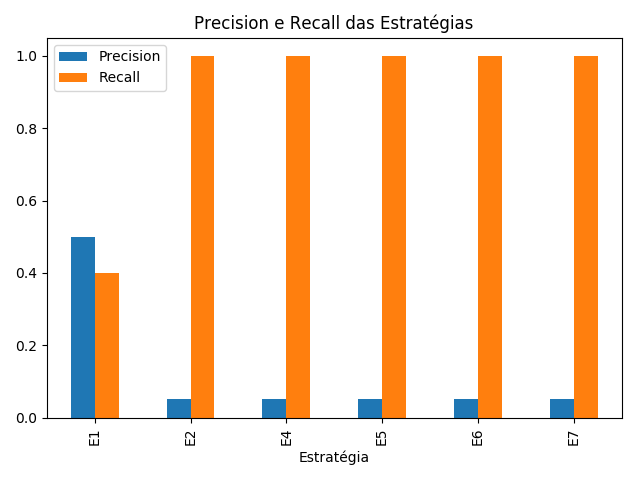

In [79]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [68]:
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.500000,0.4
E2,E2,0.050505,1.0
E4,E4,0.050505,1.0
E5,E5,0.050505,1.0
E6,E6,0.050505,1.0
E7,E7,0.050505,1.0


In [69]:
df.to_csv("estrategias.csv")